In [174]:
import pandas as pd
import numpy as np
import wandb

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from natsort import natsorted

In [175]:
sns.set_context("paper")
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [176]:
api = wandb.Api()

In [177]:
def load_runs(runs, filter_summary=True, preprocess_fn=None):
    summary_list, config_list, run_list, prep_list = [], [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        run_list.append({
            'name': run.name,
            'group': run.group,
        })
        if preprocess_fn is not None:
            prep_list.append(preprocess_fn(run))

    summary = pd.json_normalize(summary_list).add_prefix('summary.')
    if filter_summary:
        summary = summary[summary.columns.intersection([
            'summary.eval/test/lp/accuracy',
            'summary.eval/test/cf/y/accuracy',
            'summary.eval/test/cl/y/accuracy',
            'summary.eval/test/cf/label_snapshot_7/accuracy',
            'summary.eval/test/cf/label_snapshot_10/accuracy',
            'summary.eval/test/cf/louvain/accuracy',
            'summary.eval/test/clu/modularity',
            'summary.eval/test/clu/davies_bouldin_score',
            'summary.eval/test/clu/y/nmi',
            'summary.eval/test/clu/label_snapshot_7/nmi',
            'summary.eval/test/clu/label_snapshot_10/nmi',
            'summary.eval/test/clu/louvain/nmi',
        ])]

    config = pd.json_normalize(config_list).add_prefix('config.')
    runs = pd.DataFrame(run_list)
    prep = pd.DataFrame(prep_list) if preprocess_fn is not None else None

    res =  pd.concat([summary, config, runs], axis=1)
    if prep is not None:
        res = pd.concat([res, prep], axis=1)
    res['model'] = res['config.model']
    return res


# Perfomance

In [178]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {'$in': [
        "benchmark_mgtcom_topo",
        "baseline_mgtcom_topo2",
        "benchmark_mgtcom_feat",
        "benchmark_mgtcom_combi",
        "benchmark_mgtcom_tempo",
        "baseline_ComE64",
        "baseline_GEMSEC64",
        "baseline_node2vec",
        "baseline_ctdne",
        "baseline_cpgnn",
        "baseline_graphsage",
    ]}},
    {"state": {'$in': ['finished', 'crashed']}},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 147 runs


In [179]:
result_df = runs_df.copy()
result_df['dataset'] = result_df['config.dataset']
result_df = result_df[~result_df['dataset'].isin(['StarWars'])]

result_df.loc[result_df['dataset'] == 'ICEWS0515', 'summary.eval/test/cf/label_snapshot_7/accuracy'] = \
    result_df[result_df['dataset'] == 'ICEWS0515']['summary.eval/test/cf/label_snapshot_10/accuracy']
result_df.loc[result_df['dataset'] == 'ICEWS0515', 'summary.eval/test/clu/label_snapshot_7/nmi'] = \
    result_df[result_df['dataset'] == 'ICEWS0515']['summary.eval/test/clu/label_snapshot_10/nmi']

result_df.loc[result_df['dataset'] == 'SocialDistancingStudents', 'summary.eval/test/cf/label_snapshot_7/accuracy'] = \
    result_df[result_df['dataset'] == 'SocialDistancingStudents']['summary.eval/test/cf/label_snapshot_10/accuracy']
result_df.loc[result_df['dataset'] == 'SocialDistancingStudents', 'summary.eval/test/clu/label_snapshot_7/nmi'] = \
    result_df[result_df['dataset'] == 'SocialDistancingStudents']['summary.eval/test/clu/label_snapshot_10/nmi']

result_df = result_df\
    .sort_values(by='dataset', ascending=True)\
    .groupby(['dataset', 'model'])\
    .agg({
        'summary.eval/test/lp/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/y/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/label_snapshot_7/accuracy': ['mean', 'std'],
        'summary.eval/test/clu/modularity': ['mean', 'std'],
        'summary.eval/test/clu/davies_bouldin_score': ['mean', 'std'],
        'summary.eval/test/clu/y/nmi': ['mean', 'std'],
        'summary.eval/test/clu/label_snapshot_7/nmi': ['mean', 'std'],
        'summary.eval/test/clu/louvain/nmi': ['mean', 'std'],
    }) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/clu/modularity': 'clu_modularity',
        'summary.eval/test/clu/davies_bouldin_score': 'clu_dbs',
        'summary.eval/test/clu/y/nmi': 'clu_y_nmi',
        'summary.eval/test/clu/label_snapshot_7/nmi': 'clu_tempo_nmi',
        'summary.eval/test/clu/louvain/nmi': 'clu_louvain_nmi',
    })

for metric in ['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_tempo_accuracy', 'clu_modularity', 'clu_dbs', 'clu_y_nmi', 'clu_tempo_nmi', 'clu_louvain_nmi']:
    # result_df[f'{metric}_fmt'] = result_df[metric].apply(lambda x: f'{x["mean"]:.3f} ± {x["std"]:.3f}', axis=1)
    result_df[f'{metric}_fmt'] = result_df[metric].apply(lambda x: f'{x["mean"]:.3f}', axis=1)

result_df

lp_accuracy            \
                                                    mean       std   
dataset                  model                                       
Cora                     CP-GNN                 0.828598  0.030132   
                         ComE                   0.961648       NaN   
                         GEMSEC                 0.922822  0.004018   
                         GraphSAGEModel         0.505445  0.001004   
                         Het2VecClusModel       0.938920  0.005818   
                         MGCOMFeatTopoModel     0.958333  0.001339   
DBLPHCN                  CP-GNN                 0.522384  0.026175   
                         CTDNEModel             0.700696  0.005613   
                         ComE                   0.735330  0.001502   
                         GEMSEC                 0.543860  0.059955   
                         GraphSAGEModel         0.623714       NaN   
                         Het2VecClusModel       0.709756  0.005828   
                         MGCOMCombiModel        0.743466  0.025274   
                         MGCOMFeatTempoModel    0.616757  0.032366   
                         MGCOMFeatTopoModel     0.793678  0.008226   
ICEWS0515                CP-GNN                 0.709400  0.088671   
                         CTDNEModel             0.920750  0.003182   
                         ComE                   0.880350  0.002475   
                         GEMSEC                 0.767800  0.051619   
                         GraphSAGEModel         0.525500       NaN   
                         Het2VecClusModel       0.936400  0.003394   
                         MGCOMCombiModel        0.902700       NaN   
                         MGCOMFeatTempoModel    0.894920  0.001217   
                         MGCOMFeatTopoModel     0.944650  0.003618   
IMDB5000                 CP-GNN                 0.597850  0.085206   
                         CTDNEModel             0.727850  0.000919   
                         ComE                   0.665900  0.001273   
                         GEMSEC                 0.636500  0.006223   
                         GraphSAGEModel         0.713600       NaN   
                         Het2VecClusModel       0.757400  0.002687   
                         MGCOMCombiModel        0.720650  0.013223   
                         MGCOMFeatTempoModel    0.723600       NaN   
                         MGCOMFeatTopoModel     0.772654  0.019072   
SocialDistancingStudents CTDNEModel             0.955100       NaN   
                         ComE                   0.757600       NaN   
                         GEMSEC                 0.877900       NaN   
                         GraphSAGEModel         0.922000       NaN   
                         Het2VecClusModel       0.953100  0.002546   
                         MGCOMCombiModel        0.933700       NaN   
                         MGCOMFeatTempoModel    0.616300       NaN   
                         MGCOMFeatTopoModel     0.956050  0.002475   

                                             cf_y_accuracy            \
                                                      mean       std   
dataset                  model                                         
Cora                     CP-GNN                   0.780465  0.018539   
                         ComE                     0.864106       NaN   
                         GEMSEC                   0.844904  0.020367   
                         GraphSAGEModel           0.658789  0.015667   
                         Het2VecClusModel         0.798252  0.004452   
                         MGCOMFeatTopoModel       0.853951  0.000261   
DBLPHCN                  CP-GNN                   0.505733  0.056247   
                         CTDNEModel               0.809150  0.005155   
                         ComE                     0.842400  0.005376   
                         GEMSEC                   0.831400  0.004363   
                         Gra

In [180]:
format_df = result_df[[
    'lp_accuracy_fmt',
    'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt',
    'clu_modularity_fmt', 'clu_dbs_fmt',
    'clu_y_nmi_fmt', 'clu_tempo_nmi_fmt', 'clu_louvain_nmi_fmt'
]].copy() \
    .reset_index()

format_df.columns = format_df.columns.droplevel(1)
format_df = format_df \
    .melt(id_vars=['dataset', 'model'], value_vars=[
        'lp_accuracy_fmt',
        'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt',
        'clu_modularity_fmt', 'clu_dbs_fmt',
        'clu_y_nmi_fmt', 'clu_tempo_nmi_fmt', 'clu_louvain_nmi_fmt'
    ]) \
    .replace({
        'Het2VecClusModel': 'Node2Vec',
        'CTDNEModel': 'CTDNE',
        'GraphSAGEModel': 'GraphSAGE',
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'DBLP-HCN': 'DBLP',
        'ICEWS0515': 'ICEWS',
        'IMDB5000': 'IMDB',
        'SocialDistancingStudents': 'SDS',
        'lp_accuracy_fmt': '$LP_{ACC}$',
        'cf_y_accuracy_fmt': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy_fmt': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy_fmt': '$CF_{ACC}$ $L_G$',
        'clu_modularity_fmt': 'Modularity',
        'clu_dbs_fmt': 'Davies-Bouldin',
        'clu_y_nmi_fmt': '$COM_{NMI}$ $L_y$',
        'clu_tempo_nmi_fmt': '$COM_{NMI}$ $L_\mathcal{T}$',
        'clu_louvain_nmi_fmt': '$COM_{NMI}$ $L_G$',
    }) \
    .pivot(index=['dataset', 'variable'], columns='model', values=['value']) \
    .fillna('-') \

format_df.columns = format_df.columns.droplevel(0)
format_df = format_df[['GraphSAGE', 'Node2Vec', 'ComE', 'GEMSEC', 'CTDNE', 'CP-GNN', '$MGTCOM$', '$MGTCOM^{\mathcal{T}}$', '$MGTCOM^{\mathcal{E}}$']]
format_df

model                               GraphSAGE Node2Vec   ComE GEMSEC  CTDNE  \
dataset variable                                                              
Cora    $CF_{ACC}$ $L_\mathcal{T}$        nan      nan    nan    nan      -   
        $CF_{ACC}$ $L_y$                0.659    0.798  0.864  0.845      -   
        $COM_{NMI}$ $L_G$               0.507    0.543  0.635  0.632      -   
        $COM_{NMI}$ $L_\mathcal{T}$       nan      nan    nan    nan      -   
        $COM_{NMI}$ $L_y$               0.376    0.345  0.434  0.437      -   
        $LP_{ACC}$                      0.505    0.939  0.962  0.923      -   
        Davies-Bouldin                  1.526    1.250  2.021  1.500      -   
        Modularity                      0.636    0.691  0.785  0.780      -   
DBLPHCN $CF_{ACC}$ $L_\mathcal{T}$      0.309    0.308  0.328  0.324  0.488   
        $CF_{ACC}$ $L_y$                0.315    0.832  0.842  0.831  0.809   
        $COM_{NMI}$ $L_G$               0.040    0.425  0.470  0.314  0.401   
        $COM_{NMI}$ $L_\mathcal{T}$     0.006    0.033  0.025  0.022  0.059   
        $COM_{NMI}$ $L_y$               0.051    0.549  0.463  0.385  0.537   
        $LP_{ACC}$                      0.624    0.710  0.735  0.544  0.701   
        Davies-Bouldin                  0.472    2.305  2.205  4.056  1.206   
        Modularity                      0.028    0.662  0.636  0.492  0.642   
ICEWS   $CF_{ACC}$ $L_\mathcal{T}$      0.294    0.301  0.264  0.310  0.285   
        $CF_{ACC}$ $L_y$                  nan      nan    nan    nan    nan   
        $COM_{NMI}$ $L_G$               0.227    0.354  0.548  0.309  0.347   
        $COM_{NMI}$ $L_\mathcal{T}$     0.018    0.040  0.015  0.022  0.022   
        $COM_{NMI}$ $L_y$                 nan      nan    nan    nan    nan   
        $LP_{ACC}$                      0.525    0.936  0.880  0.768  0.921   
        Davies-Bouldin                  1.027    1.697  2.559  3.867  1.533   
        Modularity                      0.218    0.215  0.483  0.311  0.239   
IMDB    $CF_{ACC}$ $L_\mathcal{T}$      0.346    0.373  0.394  0.380  0.488   
        $CF_{ACC}$ $L_y$                  nan      nan    nan    nan    nan   
        $COM_{NMI}$ $L_G$               0.039    0.181  0.197  0.094  0.160   
        $COM_{NMI}$ $L_\mathcal{T}$     0.022    0.025  0.031  0.013  0.065   
        $COM_{NMI}$ $L_y$                 nan      nan    nan    nan    nan   
        $LP_{ACC}$                      0.714    0.757  0.666  0.637  0.728   
        Davies-Bouldin                  0.301    1.803  3.840  4.951  1.749   
        Modularity                     -0.172    0.190  0.395  0.073  0.196   
SDS     $CF_{ACC}$ $L_\mathcal{T}$      0.521    0.445  0.386  0.384  0.447   
        $CF_{ACC}$ $L_y$                  nan      nan    nan    nan    nan   
        $COM_{NMI}$ $L_G$               0.186    0.277  0.346  0.117  0.233   
        $COM_{NMI}$ $L_\mathcal{T}$     0.250    0.149  0.117  0.015  0.161   
        $COM_{NMI}$ $L_y$                 nan      nan    nan    nan    nan   
        $LP_{ACC}$                      0.922    0.953  0.758  0.878  0.955   
        Davies-Bouldin                  1.108    2.355  3.986  3.410  2.890   
        Modularity                      0.088    0.163  0.301  0.037  0.016   

model                                CP-GNN $MGTCOM$ $MGTCOM^{\mathcal{T}}$  \
dataset variable                                                              
Cora    $CF_{ACC}$ $L_\mathcal{T}$      nan        -                      -   
        $CF_{ACC}$ $L_y$              0.780        -                      -   
        $COM_{NMI}$ $L_G$             0.501        -                      -   
        $COM_{NMI}$ $L_\mathcal{T}$     nan        -                      -   
        $COM_{NMI}$ $L_y$             0.370        -                      -   
        $LP_{ACC}$                    0.829        -                      -   
        Davies-Bouldin                2.634      

In [181]:
print(format_df.to_latex(escape=False))
Path('figs/performance.tex').write_text(format_df.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
    & model & GraphSAGE & Node2Vec &   ComE & GEMSEC &  CTDNE &  CP-GNN & $MGTCOM$ & $MGTCOM^{\mathcal{T}}$ & $MGTCOM^{\mathcal{E}}$ \\
dataset & variable &           &          &        &        &        &         &          &                        &                        \\
\midrule
Cora & $CF_{ACC}$ $L_\mathcal{T}$ &       nan &      nan &    nan &    nan &      - &     nan &        - &                      - &                    nan \\
    & $CF_{ACC}$ $L_y$ &     0.659 &    0.798 &  0.864 &  0.845 &      - &   0.780 &        - &                      - &                  0.854 \\
    & $COM_{NMI}$ $L_G$ &     0.507 &    0.543 &  0.635 &  0.632 &      - &   0.501 &        - &                      - &                  0.643 \\
    & $COM_{NMI}$ $L_\mathcal{T}$ &       nan &      nan &    nan &    nan &      - &     nan &        - &                      - &                    nan \\
    & $COM_{NMI}$ $L_y$ &     0.376 &    0.345 &  0.434 &  0.43

/tmp/ipykernel_185127/2299839813.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(format_df.to_latex(escape=False))
/tmp/ipykernel_185127/2299839813.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Path('figs/performance.tex').write_text(format_df.to_latex(escape=False))


6285

# Experiment Inference

In [182]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": "ablation_inference"},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 136 runs


In [183]:
result_df = runs_df.copy()
result_df['train_ratio'] = (1 - result_df['config.split_num_val'] - result_df['config.split_num_test']).round(2)
result_df = result_df\
    .sort_values(by='train_ratio', ascending=True)\
    .groupby(['model', 'train_ratio'])\
    .agg({
        'summary.eval/test/lp/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/y/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/label_snapshot_7/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/louvain/accuracy': ['mean', 'std'],
    }) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    })

for metric in ['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']:
    # result_df[f'{metric}_fmt'] = result_df[metric].apply(lambda x: f'{x["mean"]:.3f} ± {x["std"]:.3f}', axis=1)
    result_df[f'{metric}_fmt'] = result_df[metric].apply(lambda x: f'{x["mean"]:.3f}', axis=1)

result_df

lp_accuracy           cf_y_accuracy            \
                                       mean       std          mean       std   
model               train_ratio                                                 
MGCOMCombiModel     0.1            0.686375  0.036290      0.427750  0.055435   
                    0.2            0.727725  0.043467      0.474150  0.036563   
                    0.3            0.773725  0.030924      0.548500  0.068826   
                    0.4            0.754875  0.041170      0.571050  0.082035   
                    0.5            0.780400  0.007920      0.637800  0.027719   
                    0.6            0.832900  0.044244      0.798800  0.063566   
                    0.7            0.860500  0.001114      0.861200  0.008861   
                    0.8            0.886600  0.012497      0.898750  0.018450   
                    0.9            0.871900  0.006564      0.927067  0.008547   
MGCOMFeatTempoModel 0.1            0.636400  0.047466      0.310286  0.011992   
                    0.2            0.678229  0.020621      0.310114  0.020214   
                    0.3            0.668757  0.049209      0.332171  0.029362   
                    0.4            0.638514  0.047848      0.324429  0.027519   
                    0.5            0.671233  0.024142      0.365100  0.056506   
                    0.6            0.652750  0.041782      0.342800  0.038243   
                    0.7            0.643700  0.057124      0.337433  0.032274   
                    0.8            0.670720  0.028526      0.351840  0.033158   
                    0.9            0.638250  0.012242      0.348050  0.007567   
MGCOMFeatTopoModel  0.1            0.701940  0.034214      0.483800  0.026827   
                    0.2            0.778217  0.055486      0.498833  0.024650   
                    0.3            0.851200  0.012288      0.640333  0.073862   
                    0.4            0.875680  0.017323      0.637440  0.087363   
                    0.5            0.919220  0.011841      0.728520  0.072240   
                    0.6            0.935900  0.008338      0.788000  0.024686   
                    0.7            0.957875  0.009973      0.888450  0.027570   
                    0.8            0.972317  0.006855      0.933333  0.015479   
                    0.9            0.963433  0.014720      0.890567  0.060082   

                                cf_tempo_accuracy            \
                                             mean       std   
model               train_ratio                               
MGCOMCombiModel     0.1                  0.323300  0.004692   
                    0.2                  0.332900  0.008041   
                    0.3                  0.370000  0.023517   
                    0.4                  0.407850  0.028520   
                    0.5                  0.482800  0.017253   
                    0.6                  0.565733  0.019092   
                    0.7                  0.663867  0.017081   
                    0.8                  0.727950  0.011811   
                    0.9                  0.755200  0.089420   
MGCOMFeatTempoModel 0.1                  0.323000  0.006126   
                    0.2                  0.341257  0.007118   
                    0.3                  0.371571  0.032168   
                    0.4                  0.402943  0.041778   
                    0.5                  0.485300  0.049357   
                    0.6                  0.532133  0.062215   
                    0.7                  0.561733  0.085785   
                    0.8                  0.676720  0.095222   
                    0.9                  0.610300  0.116920   
MGCOMFeatTopoModel  0.1                  0.312120  0.005553   
                    0.2                  0.311000  0.007046   
                    0.3                  0.306200  0.007364   
                    0.4                  0.308000  0.007106   
                    0.5   

## Table

In [184]:
format_df = result_df[[
    'lp_accuracy_fmt', 'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt', 'cf_louvain_accuracy_fmt'
]].copy() \
    .reset_index()

format_df.columns = format_df.columns.droplevel(1)
format_df = format_df \
    .melt(id_vars=['model', 'train_ratio'], value_vars=['lp_accuracy_fmt', 'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt', 'cf_louvain_accuracy_fmt']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy_fmt': '$LP_{ACC}$',
        'cf_y_accuracy_fmt': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy_fmt': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy_fmt': '$CF_{ACC}$ $L_G$',
    }) \
    .pivot(index=['model', 'variable'], columns='train_ratio', values=['value'])
format_df

value                       \
train_ratio                                          0.1    0.2    0.3    0.4   
model                  variable                                                 
$MGTCOM$               $CF_{ACC}$ $L_G$            0.347  0.368  0.419  0.432   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.323  0.333  0.370  0.408   
                       $CF_{ACC}$ $L_y$            0.428  0.474  0.548  0.571   
                       $LP_{ACC}$                  0.686  0.728  0.774  0.755   
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.382  0.412  0.479  0.491   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.312  0.311  0.306  0.308   
                       $CF_{ACC}$ $L_y$            0.484  0.499  0.640  0.637   
                       $LP_{ACC}$                  0.702  0.778  0.851  0.876   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.227  0.228  0.248  0.242   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.323  0.341  0.372  0.403   
                       $CF_{ACC}$ $L_y$            0.310  0.310  0.332  0.324   
                       $LP_{ACC}$                  0.636  0.678  0.669  0.639   

                                                                               \
train_ratio                                          0.5    0.6    0.7    0.8   
model                  variable                                                 
$MGTCOM$               $CF_{ACC}$ $L_G$            0.473  0.580  0.626  0.685   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.483  0.566  0.664  0.728   
                       $CF_{ACC}$ $L_y$            0.638  0.799  0.861  0.899   
                       $LP_{ACC}$                  0.780  0.833  0.861  0.887   
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.555  0.600  0.665  0.721   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.314  0.305  0.312  0.316   
                       $CF_{ACC}$ $L_y$            0.729  0.788  0.888  0.933   
                       $LP_{ACC}$                  0.919  0.936  0.958  0.972   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.248  0.237  0.225  0.234   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.485  0.532  0.562  0.677   
                       $CF_{ACC}$ $L_y$            0.365  0.343  0.337  0.352   
                       $LP_{ACC}$                  0.671  0.653  0.644  0.671   

                                                          
train_ratio                                          0.9  
model                  variable                           
$MGTCOM$               $CF_{ACC}$ $L_G$            0.736  
                       $CF_{ACC}$ $L_\mathcal{T}$  0.755  
                       $CF_{ACC}$ $L_y$            0.927  
                       $LP_{ACC}$                  0.872  
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.706  
                       $CF_{ACC}$ $L_\mathcal{T}$  0.311  
                       $CF_{ACC}$ $L_y$            0.891  
                       $LP_{ACC}$                  0.963  
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.221  
                       $CF_{ACC}$ $L_\mathcal{T}$  0.610  
                       $CF_{ACC}$ $L_y$            0.348  
                       $LP_{ACC}$                  0.638

In [185]:
print(format_df.to_latex(escape=False))
Path('figs/inference.tex').write_text(format_df.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
                       & {} & \multicolumn{9}{l}{value} \\
                       & train_ratio &    0.1 &    0.2 &    0.3 &    0.4 &    0.5 &    0.6 &    0.7 &    0.8 &    0.9 \\
model & variable &        &        &        &        &        &        &        &        &        \\
\midrule
$MGTCOM$ & $CF_{ACC}$ $L_G$ &  0.347 &  0.368 &  0.419 &  0.432 &  0.473 &  0.580 &  0.626 &  0.685 &  0.736 \\
                       & $CF_{ACC}$ $L_\mathcal{T}$ &  0.323 &  0.333 &  0.370 &  0.408 &  0.483 &  0.566 &  0.664 &  0.728 &  0.755 \\
                       & $CF_{ACC}$ $L_y$ &  0.428 &  0.474 &  0.548 &  0.571 &  0.638 &  0.799 &  0.861 &  0.899 &  0.927 \\
                       & $LP_{ACC}$ &  0.686 &  0.728 &  0.774 &  0.755 &  0.780 &  0.833 &  0.861 &  0.887 &  0.872 \\
$MGTCOM^{\mathcal{E}}$ & $CF_{ACC}$ $L_G$ &  0.382 &  0.412 &  0.479 &  0.491 &  0.555 &  0.600 &  0.665 &  0.721 &  0.706 \\
                       & $CF_{ACC}$ $L_\mathcal{T}$ 

/tmp/ipykernel_185127/2043333108.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(format_df.to_latex(escape=False))
/tmp/ipykernel_185127/2043333108.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Path('figs/inference.tex').write_text(format_df.to_latex(escape=False))


1864

## Plots

In [186]:
plot_df = runs_df.copy()
plot_df['train_ratio'] = (1 - plot_df['config.split_num_val'] - plot_df['config.split_num_test']).round(2)
plot_df = plot_df\
    .sort_values(by='train_ratio', ascending=True) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    }) \
    .melt(id_vars=['model', 'train_ratio'], value_vars=['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '(a)  $LP_{ACC}$',
        'cf_y_accuracy': '(b)  $CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '(c)  $CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '(d)  $CF_{ACC}$ $L_G$',
    }) \

plot_df

,model,train_ratio,variable,value
0,$MGTCOM^{\mathcal{T}}$,0.1,(a) $LP_{ACC}$,0.6421
1,$MGTCOM$,0.1,(a) $LP_{ACC}$,0.6813
2,$MGTCOM$,0.1,(a) $LP_{ACC}$,0.6391
3,$MGTCOM^{\mathcal{E}}$,0.1,(a) $LP_{ACC}$,0.7326
4,$MGTCOM^{\mathcal{T}}$,0.1,(a) $LP_{ACC}$,0.6461
...,...,...,...,...
539,$MGTCOM^{\mathcal{E}}$,0.9,(d) $CF_{ACC}$ $L_G$,0.7854
540,$MGTCOM^{\mathcal{T}}$,0.9,(d) $CF_{ACC}$ $L_G$,0.2258
541,$MGTCOM^{\mathcal{T}}$,0.9,(d) $CF_{ACC}$ $L_G$,0.2290
542,$MGTCOM^{\mathcal{T}}$,NaN,(d) $CF_{ACC}$ $L_G$,NaN


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


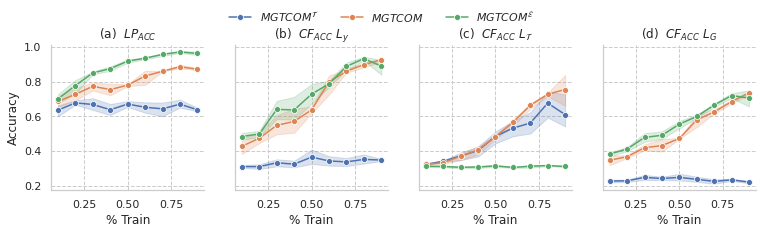

In [187]:
g = sns.FacetGrid(plot_df, hue='model', col='variable', gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'train_ratio', 'value', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels("% Train", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
g.fig.savefig('figs/inference.pdf', format='pdf', bbox_inches='tight')

# Embed Ratio

In [188]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": ["abl_emb_ratio", "abl_emb_ratio_tempo"]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 129 runs


In [189]:
result_df = runs_df.copy()
result_df['embed_node_ratio'] = result_df['config.embed_node_ratio']
result_df = result_df\
    .sort_values(by='embed_node_ratio', ascending=True)\
    .groupby(['model', 'embed_node_ratio'])\
    .agg({
        'summary.eval/test/lp/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/y/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/label_snapshot_7/accuracy': ['mean', 'std'],
        'summary.eval/test/cf/louvain/accuracy': ['mean', 'std'],
    }) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    })

for metric in ['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']:
    result_df[f'{metric}_fmt'] = result_df[metric].apply(lambda x: f'{x["mean"]:.3f} ± {x["std"]:.3f}', axis=1)

result_df

lp_accuracy           cf_y_accuracy  \
                                            mean       std          mean   
model               embed_node_ratio                                       
MGCOMFeatTempoModel 0.00                0.603070  0.071182      0.451075   
                    0.02                0.624357  0.016512      0.565625   
                    0.05                0.630006  0.018902      0.473520   
                    0.07                0.629946  0.011543      0.506680   
                    0.10                0.627556  0.021625      0.535160   
                    0.20                0.631579  0.012478      0.523200   
                    0.30                0.621849  0.003945      0.407533   
                    0.40                0.630331  0.009165      0.428800   
                    0.50                0.598349  0.073376      0.426800   
                    0.60                0.627042  0.011668      0.388467   
                    0.70                0.623355  0.017549      0.383725   
                    0.80                0.618062  0.014896      0.417900   
                    0.90                0.616392  0.015208      0.377950   
                    1.00                0.617589  0.014559      0.341975   
MGCOMFeatTopoModel  0.00                0.773745  0.011407      0.725733   
                    0.02                0.790885  0.005529      0.886267   
                    0.05                0.790936  0.005380      0.866400   
                    0.07                0.789423  0.009783      0.892933   
                    0.10                0.791994  0.001213      0.881000   
                    0.20                0.794112  0.002690      0.854267   
                    0.30                0.787205  0.005113      0.855000   
                    0.40                0.796431  0.007488      0.871067   
                    0.50                0.793406  0.011086      0.822200   
                    0.60                0.789575  0.014369      0.853267   
                    0.70                0.793608  0.004925      0.849867   
                    0.80                0.794263  0.005178      0.824800   
                    0.90                0.783222  0.011384      0.837733   
                    1.00                0.783525  0.006211      0.846267   

                                               cf_tempo_accuracy            \
                                           std              mean       std   
model               embed_node_ratio                                         
MGCOMFeatTempoModel 0.00              0.039369          0.384125  0.060697   
                    0.02              0.057289          0.344025  0.034089   
                    0.05              0.118629          0.332560  0.013163   
                    0.07              0.033452          0.338320  0.020331   
                    0.10              0.031285          0.335600  0.012890   
                    0.20              0.122750          0.332667  0.013050   
                    0.30              0.098896          0.333800  0.019399   
                    0.40              0.047757          0.338350  0.013767   
                    0.50              0.097041          0.343229  0.038211   
                    0.60              0.014100          0.568867  0.106847   
                    0.70              0.088186          0.437600  0.160197   
                    0.80              0.099308          0.480825  0.200658   
                    0.90              0.084495          0.439017  0.152497   
                    1.00              0.046146          0.535950  0.201670   
MGCOMFeatTopoModel  0.00              0.040603          0.317200  0.006521   
                    0.02              0.004688          0.322267  0.005662   
                    0.05              0.016093          0.313067  0.004110   
                    0.07              0.016914          0.312133  0.003449   
                    0.10              0.00

## Table

In [190]:
format_df = result_df[[
    'lp_accuracy_fmt', 'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt', 'cf_louvain_accuracy_fmt'
]].copy() \
    .reset_index()

format_df.columns = format_df.columns.droplevel(1)
format_df = format_df \
    .melt(id_vars=['model', 'embed_node_ratio'], value_vars=['lp_accuracy_fmt', 'cf_y_accuracy_fmt', 'cf_tempo_accuracy_fmt', 'cf_louvain_accuracy_fmt']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy_fmt': '$LP_{ACC}$',
        'cf_y_accuracy_fmt': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy_fmt': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy_fmt': '$CF_{ACC}$ $L_G$',
    }) \
    .pivot(index=['model', 'variable'], columns='embed_node_ratio', values=['value'])
format_df

value  \
embed_node_ratio                                            0.00   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.556 ± 0.056   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.317 ± 0.007   
                       $CF_{ACC}$ $L_y$            0.726 ± 0.041   
                       $LP_{ACC}$                  0.774 ± 0.011   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.292 ± 0.025   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.384 ± 0.061   
                       $CF_{ACC}$ $L_y$            0.451 ± 0.039   
                       $LP_{ACC}$                  0.603 ± 0.071   

                                                                  \
embed_node_ratio                                            0.02   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.669 ± 0.021   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.322 ± 0.006   
                       $CF_{ACC}$ $L_y$            0.886 ± 0.005   
                       $LP_{ACC}$                  0.791 ± 0.006   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.355 ± 0.038   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.344 ± 0.034   
                       $CF_{ACC}$ $L_y$            0.566 ± 0.057   
                       $LP_{ACC}$                  0.624 ± 0.017   

                                                                  \
embed_node_ratio                                            0.05   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.662 ± 0.011   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.313 ± 0.004   
                       $CF_{ACC}$ $L_y$            0.866 ± 0.016   
                       $LP_{ACC}$                  0.791 ± 0.005   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.299 ± 0.053   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.333 ± 0.013   
                       $CF_{ACC}$ $L_y$            0.474 ± 0.119   
                       $LP_{ACC}$                  0.630 ± 0.019   

                                                                  \
embed_node_ratio                                            0.07   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.683 ± 0.011   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.312 ± 0.003   
                       $CF_{ACC}$ $L_y$            0.893 ± 0.017   
                       $LP_{ACC}$                  0.789 ± 0.010   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.313 ± 0.010   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.338 ± 0.020   
                       $CF_{ACC}$ $L_y$            0.507 ± 0.033   
                       $LP_{ACC}$                  0.630 ± 0.012   

                                                                  \
embed_node_ratio                                            0.10   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.691 ± 0.016   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.315 ± 0.009   
                       $CF_{ACC}$ $L_y$            0.881 ± 0.009   
                       $LP_{ACC}$                  0.792 ± 0.001   
$MGTCOM^{\mathcal{T}}$ $CF_{ACC}$ $L_G$            0.333 ± 0.020   
                       $CF_{ACC}$ $L_\mathcal{T}$  0.336 ± 0.013   
                       $CF_{ACC}$ $L_y$            0.535 ± 0.031   
                       $LP_{ACC}$                  0.628 ± 0.022   

                                                                  \
embed_node_ratio                                            0.20   
model                  variable                                    
$MGTCOM^{\mathcal{E}}$ $CF_{ACC}$ $L_G$            0.685 ± 0.022   
                       $CF_{ACC}$ $L_\math

In [191]:
print(format_df.to_latex(escape=False))
Path('figs/embed_ratio.tex').write_text(format_df.to_latex(escape=False))

\begin{tabular}{llllllllllllllll}
\toprule
                       & {} & \multicolumn{14}{l}{value} \\
                       & embed_node_ratio &           0.00 &           0.02 &           0.05 &           0.07 &           0.10 &           0.20 &           0.30 &           0.40 &           0.50 &           0.60 &           0.70 &           0.80 &           0.90 &           1.00 \\
model & variable &                &                &                &                &                &                &                &                &                &                &                &                &                &                \\
\midrule
$MGTCOM^{\mathcal{E}}$ & $CF_{ACC}$ $L_G$ &  0.556 ± 0.056 &  0.669 ± 0.021 &  0.662 ± 0.011 &  0.683 ± 0.011 &  0.691 ± 0.016 &  0.685 ± 0.022 &  0.677 ± 0.032 &  0.693 ± 0.017 &  0.669 ± 0.019 &  0.685 ± 0.047 &  0.679 ± 0.012 &  0.674 ± 0.032 &  0.675 ± 0.018 &  0.676 ± 0.023 \\
                       & $CF_{ACC}$ $L_\mathcal{T}$ &  0.317 ± 0

/tmp/ipykernel_185127/478620223.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(format_df.to_latex(escape=False))
/tmp/ipykernel_185127/478620223.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Path('figs/embed_ratio.tex').write_text(format_df.to_latex(escape=False))


2951

## Plots

In [192]:
plot_df = runs_df.copy()
plot_df['embed_node_ratio'] = plot_df['config.embed_node_ratio']
plot_df = plot_df\
    .sort_values(by='embed_node_ratio', ascending=True) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    }) \
    .melt(id_vars=['model', 'embed_node_ratio'], value_vars=['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '(a)  $LP_{ACC}$',
        'cf_y_accuracy': '(b)  $CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '(c)  $CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '(d)  $CF_{ACC}$ $L_G$',
    }) \

plot_df

,model,embed_node_ratio,variable,value
0,$MGTCOM^{\mathcal{E}}$,0.0,(a) $LP_{ACC}$,0.760587
1,$MGTCOM^{\mathcal{T}}$,0.0,(a) $LP_{ACC}$,0.624168
2,$MGTCOM^{\mathcal{E}}$,0.0,(a) $LP_{ACC}$,0.780853
3,$MGTCOM^{\mathcal{T}}$,0.0,(a) $LP_{ACC}$,0.430732
4,$MGTCOM^{\mathcal{E}}$,0.0,(a) $LP_{ACC}$,0.779794
...,...,...,...,...
511,$MGTCOM^{\mathcal{E}}$,1.0,(d) $CF_{ACC}$ $L_G$,0.671800
512,$MGTCOM^{\mathcal{T}}$,1.0,(d) $CF_{ACC}$ $L_G$,0.205000
513,$MGTCOM^{\mathcal{E}}$,1.0,(d) $CF_{ACC}$ $L_G$,0.700200
514,$MGTCOM^{\mathcal{T}}$,1.0,(d) $CF_{ACC}$ $L_G$,0.205200


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


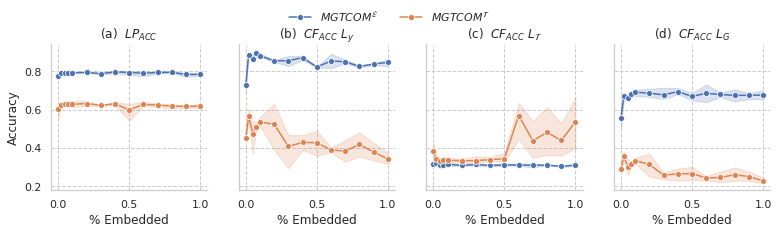

In [193]:
g = sns.FacetGrid(plot_df, hue='model', col='variable', gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'embed_node_ratio', 'value', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels("% Embedded", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
# g.set(xlim=(0, 0.5))
g.fig.savefig('figs/embed_ratio.pdf', format='pdf', bbox_inches='tight')

## Ablation Meta-Topology

In [194]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "abl_metatopo2",
        "abl_metatempo2"
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 42 runs


In [195]:
result_df = runs_df.copy()
result_df = result_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    }) \
    .melt(id_vars=['group', 'model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']) \
    .replace({
        'MGCOMFeatTempoModel': '(b)  $MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '(a)  $MGTCOM^{\mathcal{E}}$',
        'hgt_full_homo': 'HGT Homo',
        'sage_full_homo': 'SAGE Homo',
        'hgt_full': 'HGT Hetero',
        'sage_full': 'SAGE Hetero',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

plot_df = result_df

result_df

,group,model,name,variable,value
0,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,HGT Homo,$LP_{ACC}$,0.458409
1,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,SAGE Homo,$LP_{ACC}$,0.428312
2,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,HGT Homo,$LP_{ACC}$,0.462039
3,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,SAGE Homo,$LP_{ACC}$,0.431488
4,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,HGT Homo,$LP_{ACC}$,0.461131
...,...,...,...,...,...
163,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,SAGE Hetero,$CF_{ACC}$ $L_G$,0.244600
164,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,HGT Hetero,$CF_{ACC}$ $L_G$,0.294600
165,abl_metatopo2,(a) $MGTCOM^{\mathcal{E}}$,HGT Hetero,$CF_{ACC}$ $L_G$,0.641200
166,abl_metatempo2,(b) $MGTCOM^{\mathcal{T}}$,SAGE Hetero,$CF_{ACC}$ $L_G$,0.230000


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


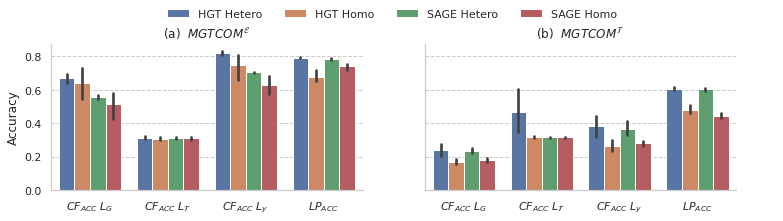

In [196]:
g = sns.FacetGrid(plot_df, col='model', gridspec_kws={"top":0.8}, col_order=['(a)  $MGTCOM^{\mathcal{E}}$', '(b)  $MGTCOM^{\mathcal{T}}$'], aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=np.unique(plot_df["name"]), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
g.fig.savefig('figs/abl_meta.pdf', format='pdf', bbox_inches='tight')

## Ablation Beta Topo Tradeoff

In [197]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "abl_beta_topo",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 17 runs


In [198]:
plot_df = runs_df.copy()
plot_df['topo_weight'] = plot_df['config.topo_weight']
plot_df = plot_df\
    .sort_values(by='topo_weight', ascending=True) \
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
        'summary.eval/test/cf/louvain/accuracy': 'cf_louvain_accuracy',
    }) \
    .melt(id_vars=['model', 'topo_weight'], value_vars=['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy', 'cf_louvain_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '(a)  $LP_{ACC}$',
        'cf_y_accuracy': '(b)  $CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '(c)  $CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '(d)  $CF_{ACC}$ $L_G$',
    }) \

plot_df

,model,topo_weight,variable,value
0,$MGTCOM$,0.15,(a) $LP_{ACC}$,0.621900
1,$MGTCOM$,0.15,(a) $LP_{ACC}$,0.617211
2,$MGTCOM$,0.15,(a) $LP_{ACC}$,0.614489
3,$MGTCOM$,0.25,(a) $LP_{ACC}$,0.728524
4,$MGTCOM$,0.25,(a) $LP_{ACC}$,0.669238
...,...,...,...,...
63,$MGTCOM$,0.60,(d) $CF_{ACC}$ $L_G$,0.689200
64,$MGTCOM$,0.75,(d) $CF_{ACC}$ $L_G$,0.709600
65,$MGTCOM$,0.75,(d) $CF_{ACC}$ $L_G$,0.707400
66,$MGTCOM$,0.85,(d) $CF_{ACC}$ $L_G$,0.718400


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


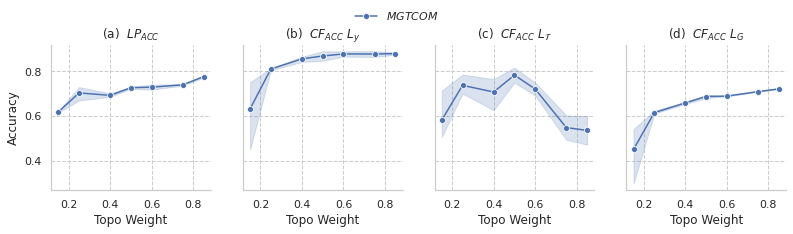

In [199]:
g = sns.FacetGrid(plot_df, hue='model', col='variable', gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'topo_weight', 'value', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels("Topo Weight", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
g.fig.savefig('figs/abl_beta_topo.pdf', format='pdf', bbox_inches='tight')

# Hyperparameters

## Topo Repr Dim

In [200]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "mgtcom_tune_reprdim3",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 47 runs


In [201]:
plot_df = runs_df.copy()
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
        'd4': '4',
        'd4h32': '4h32',
        'd8': '8',
        'd8h32': '8h32',
        'd16': '16',
        'd16h32': '16h32',
        'd32': '32',
        'd64': '64',
    }) \

plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,4h32,$LP_{ACC}$,0.735935
1,$MGTCOM^{\mathcal{E}}$,8h32,$LP_{ACC}$,0.753176
2,$MGTCOM^{\mathcal{E}}$,16h32,$LP_{ACC}$,0.767998
3,$MGTCOM^{\mathcal{E}}$,4,$LP_{ACC}$,0.729129
4,$MGTCOM^{\mathcal{E}}$,8,$LP_{ACC}$,0.770871
...,...,...,...,...
89,$MGTCOM^{\mathcal{E}}$,8,$CF_{ACC}$ $L_y$,0.594000
90,$MGTCOM^{\mathcal{E}}$,16,$CF_{ACC}$ $L_y$,0.703400
91,$MGTCOM^{\mathcal{E}}$,32,$CF_{ACC}$ $L_y$,0.798600
92,$MGTCOM^{\mathcal{E}}$,64,$CF_{ACC}$ $L_y$,0.890800


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


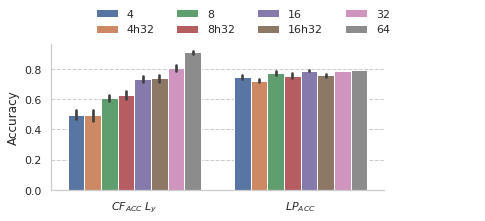

In [202]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
g.fig.savefig('figs/tune_topo_reprdim.pdf', format='pdf', bbox_inches='tight')

## Activation Function

In [245]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "abl_activation",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 12 runs


In [246]:
plot_df = runs_df.copy()
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
        'relu': 'ReLU',
        'gelu': 'GeLU',
    }) \

plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.794313
1,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.783878
2,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.798246
3,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.791289
4,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.796884
5,$MGTCOM^{\mathcal{E}}$,GeLU,$LP_{ACC}$,0.786903
6,$MGTCOM^{\mathcal{E}}$,ReLU,$LP_{ACC}$,0.782517
7,$MGTCOM^{\mathcal{E}}$,ReLU,$LP_{ACC}$,0.789776
8,$MGTCOM^{\mathcal{E}}$,ReLU,$LP_{ACC}$,0.783878
9,$MGTCOM^{\mathcal{E}}$,ReLU,$LP_{ACC}$,0.782365


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


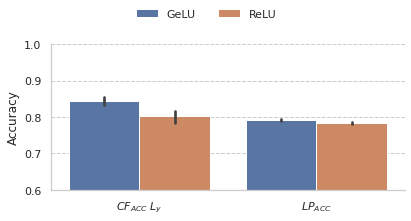

In [247]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=4, loc='upper center', title='')
g.set(ylim=(0.6, 1.0))
g.fig.savefig('figs/tune_topo_activation.pdf', format='pdf', bbox_inches='tight')

## Topo Neighbourhood Sampling

In [206]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "mgtcom_tune_neighbors3",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 26 runs


In [207]:
plot_df = runs_df.copy()
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

def reformat_name(name):
    method, neigh = name.replace('_b', '_').split('_')
    neigh = ','.join(neigh)

    return f"({neigh}) {method.upper()}"

plot_df['name'] = plot_df['name'].map(reformat_name)

plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,"(8,4) SAGE",$LP_{ACC}$,0.775862
1,$MGTCOM^{\mathcal{E}}$,"(6,2) SAGE",$LP_{ACC}$,0.790079
2,$MGTCOM^{\mathcal{E}}$,"(2,2) SAGE",$LP_{ACC}$,0.759528
3,$MGTCOM^{\mathcal{E}}$,"(3,1) SAGE",$LP_{ACC}$,0.782365
4,$MGTCOM^{\mathcal{E}}$,"(3,2) SAGE",$LP_{ACC}$,0.781912
5,$MGTCOM^{\mathcal{E}}$,"(3,2) HGT",$LP_{ACC}$,0.791894
6,$MGTCOM^{\mathcal{E}}$,"(8,4) SAGE",$LP_{ACC}$,0.775106
7,$MGTCOM^{\mathcal{E}}$,"(6,2) SAGE",$LP_{ACC}$,0.768603
8,$MGTCOM^{\mathcal{E}}$,"(2,2) SAGE",$LP_{ACC}$,0.777072
9,$MGTCOM^{\mathcal{E}}$,"(3,1) SAGE",$LP_{ACC}$,0.779341


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


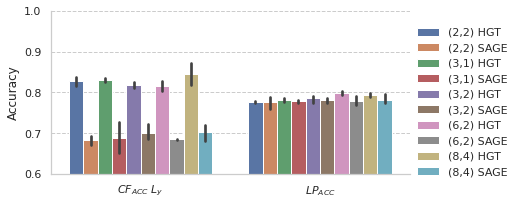

In [208]:
g = sns.FacetGrid(plot_df, gridspec_kws={"right":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=1, loc='right', title='')
g.set(ylim=(0.6, 1.0))
g.fig.savefig('figs/tune_topo_neigh.pdf', format='pdf', bbox_inches='tight')

In [209]:
# TODO: validation curve

## Topo Margin

In [210]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "mgtcom_tune_hmargin3",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 35 runs


In [211]:
plot_df = runs_df.copy()
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

def reformat_name(name):
    method, neigh = name.replace('_b', '_').split('_')
    neigh = ','.join(neigh)

    return f"({neigh}) {method.upper()}"

plot_df['name'] = plot_df['name'].map(lambda x: "${}$".format(x.replace('hmargin=', '\Delta=')))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,$\Delta=16$,$LP_{ACC}$,0.738355
1,$MGTCOM^{\mathcal{E}}$,$\Delta=8$,$LP_{ACC}$,0.757411
2,$MGTCOM^{\mathcal{E}}$,$\Delta=4$,$LP_{ACC}$,0.741379
3,$MGTCOM^{\mathcal{E}}$,$\Delta=2$,$LP_{ACC}$,0.788415
4,$MGTCOM^{\mathcal{E}}$,$\Delta=1$,$LP_{ACC}$,0.777677
...,...,...,...,...
65,$MGTCOM^{\mathcal{E}}$,$\Delta=16$,$CF_{ACC}$ $L_y$,0.743600
66,$MGTCOM^{\mathcal{E}}$,$\Delta=8$,$CF_{ACC}$ $L_y$,0.711400
67,$MGTCOM^{\mathcal{E}}$,$\Delta=4$,$CF_{ACC}$ $L_y$,0.796600
68,$MGTCOM^{\mathcal{E}}$,$\Delta=2$,$CF_{ACC}$ $L_y$,0.826200


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


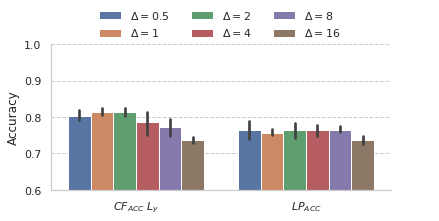

In [212]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=3, loc='upper center', title='')
g.set(ylim=(0.6, 1.0))
g.fig.savefig('figs/tune_topo_margin.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

## Topo Walk Params

In [213]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "mgtcom_tune_rw3",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 42 runs


### Context Size

In [214]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^c[0-9]*$', regex=True)]
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

plot_df['name'] = plot_df['name'].map(lambda x: "${}$".format(x.replace('c', 'l=')))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,$l=3$,$LP_{ACC}$,0.730188
1,$MGTCOM^{\mathcal{E}}$,$l=5$,$LP_{ACC}$,0.769812
2,$MGTCOM^{\mathcal{E}}$,$l=10$,$LP_{ACC}$,0.781307
3,$MGTCOM^{\mathcal{E}}$,$l=20$,$LP_{ACC}$,0.776770
4,$MGTCOM^{\mathcal{E}}$,$l=3$,$LP_{ACC}$,0.697520
5,$MGTCOM^{\mathcal{E}}$,$l=5$,$LP_{ACC}$,0.764670
6,$MGTCOM^{\mathcal{E}}$,$l=10$,$LP_{ACC}$,0.786751
7,$MGTCOM^{\mathcal{E}}$,$l=20$,$LP_{ACC}$,0.792801
8,$MGTCOM^{\mathcal{E}}$,$l=3$,$LP_{ACC}$,0.749395
9,$MGTCOM^{\mathcal{E}}$,$l=5$,$LP_{ACC}$,0.743799


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


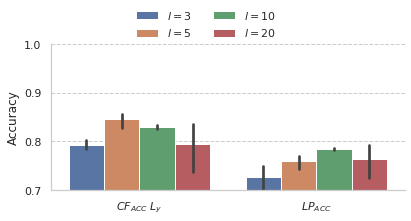

In [215]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=2, loc='upper center', title='')
g.set(ylim=(0.7, 1.0))
g.fig.savefig('figs/tune_topo_rw_ctx.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

### Num Walks

In [216]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^c[0-9]*w[0-9]*$', regex=True)]
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

plot_df['name'] = plot_df['name'].map(lambda x: "$n={}$".format(x.split('w')[1]))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,$n=5$,$LP_{ACC}$,0.794918
1,$MGTCOM^{\mathcal{E}}$,$n=10$,$LP_{ACC}$,0.797187
2,$MGTCOM^{\mathcal{E}}$,$n=20$,$LP_{ACC}$,0.764368
3,$MGTCOM^{\mathcal{E}}$,$n=20$,$LP_{ACC}$,0.789171
4,$MGTCOM^{\mathcal{E}}$,$n=30$,$LP_{ACC}$,0.800363
5,$MGTCOM^{\mathcal{E}}$,$n=5$,$LP_{ACC}$,0.797641
6,$MGTCOM^{\mathcal{E}}$,$n=10$,$LP_{ACC}$,0.768905
7,$MGTCOM^{\mathcal{E}}$,$n=20$,$LP_{ACC}$,0.779643
8,$MGTCOM^{\mathcal{E}}$,$n=20$,$LP_{ACC}$,0.797943
9,$MGTCOM^{\mathcal{E}}$,$n=30$,$LP_{ACC}$,0.782970


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


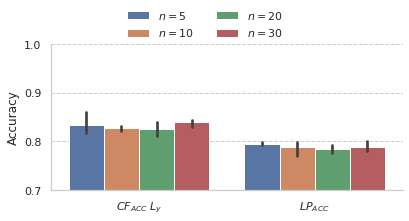

In [217]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=2, loc='upper center', title='')
g.set(ylim=(0.7, 1.0))
g.fig.savefig('figs/tune_topo_rw_nwalks.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

### Q

In [218]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^c[0-9]*q[0-9.]*$', regex=True)]
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

plot_df['name'] = plot_df['name'].map(lambda x: "$q={}$".format(x.split('q')[1]))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{E}}$,$q=1$,$LP_{ACC}$,0.778282
1,$MGTCOM^{\mathcal{E}}$,$q=0.1$,$LP_{ACC}$,0.785844
2,$MGTCOM^{\mathcal{E}}$,$q=0.25$,$LP_{ACC}$,0.790532
3,$MGTCOM^{\mathcal{E}}$,$q=0.5$,$LP_{ACC}$,0.798094
4,$MGTCOM^{\mathcal{E}}$,$q=1$,$LP_{ACC}$,0.792801
5,$MGTCOM^{\mathcal{E}}$,$q=0.1$,$LP_{ACC}$,0.792650
6,$MGTCOM^{\mathcal{E}}$,$q=0.25$,$LP_{ACC}$,0.782668
7,$MGTCOM^{\mathcal{E}}$,$q=0.5$,$LP_{ACC}$,0.777072
8,$MGTCOM^{\mathcal{E}}$,$q=1$,$LP_{ACC}$,0.786449
9,$MGTCOM^{\mathcal{E}}$,$q=0.1$,$LP_{ACC}$,0.794767


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


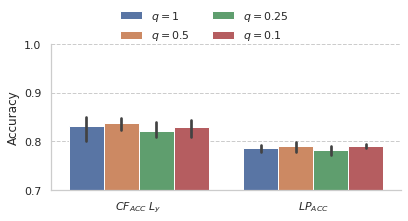

In [219]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=[
    '$q=1$',
    '$q=0.5$',
    '$q=0.25$',
    '$q=0.1$'
], order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=2, loc='upper center', title='')
g.set(ylim=(0.7, 1.0))
g.fig.savefig('figs/tune_topo_rw_q.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

## Tempo Walk Params

In [220]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "mgtcom_tune_ballroom",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")
runs_df = load_runs(runs)

Found 83 runs


### Context Size

In [221]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^[0-9]?c[0-9]*$', regex=True)]
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cf/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['cf_tempo_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \
    # .melt(id_vars=['model', 'name'], value_vars=['lp_accuracy', 'cf_y_accuracy', 'cf_tempo_accuracy']) \

plot_df['name'] = plot_df['name'].map(lambda x: "$l={}$".format(x.split('c')[1]))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{T}}$,$l=3$,$CF_{ACC}$ $L_\mathcal{T}$,0.7526
1,$MGTCOM^{\mathcal{T}}$,$l=3$,$CF_{ACC}$ $L_\mathcal{T}$,0.8362
2,$MGTCOM^{\mathcal{T}}$,$l=5$,$CF_{ACC}$ $L_\mathcal{T}$,0.8476
3,$MGTCOM^{\mathcal{T}}$,$l=5$,$CF_{ACC}$ $L_\mathcal{T}$,0.8556
4,$MGTCOM^{\mathcal{T}}$,$l=10$,$CF_{ACC}$ $L_\mathcal{T}$,0.8614
5,$MGTCOM^{\mathcal{T}}$,$l=10$,$CF_{ACC}$ $L_\mathcal{T}$,0.8644
6,$MGTCOM^{\mathcal{T}}$,$l=20$,$CF_{ACC}$ $L_\mathcal{T}$,0.8682
7,$MGTCOM^{\mathcal{T}}$,$l=20$,$CF_{ACC}$ $L_\mathcal{T}$,0.8612
8,$MGTCOM^{\mathcal{T}}$,$l=3$,$CF_{ACC}$ $L_\mathcal{T}$,0.7426
9,$MGTCOM^{\mathcal{T}}$,$l=3$,$CF_{ACC}$ $L_\mathcal{T}$,0.7340


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


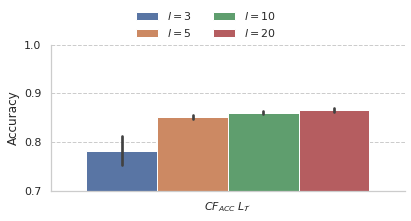

In [222]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=2, loc='upper center', title='')
g.set(ylim=(0.7, 1.0))
g.fig.savefig('figs/tune_tempo_rw_ctx.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

### Num Walks

In [223]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^[0-9]?c[0-9]*w[0-9]*$', regex=True)]
plot_df = plot_df\
    .rename(columns={
        'summary.eval/test/lp/accuracy': 'lp_accuracy',
        'summary.eval/test/cl/y/accuracy': 'cf_y_accuracy',
        'summary.eval/test/cf/label_snapshot_7/accuracy': 'cf_tempo_accuracy',
    }) \
    .melt(id_vars=['model', 'name'], value_vars=['cf_tempo_accuracy']) \
    .replace({
        'MGCOMCombiModel': '$MGTCOM$',
        'MGCOMFeatTempoModel': '$MGTCOM^{\mathcal{T}}$',
        'MGCOMFeatTopoModel': '$MGTCOM^{\mathcal{E}}$',
        'lp_accuracy': '$LP_{ACC}$',
        'cf_y_accuracy': '$CF_{ACC}$ $L_y$',
        'cf_tempo_accuracy': '$CF_{ACC}$ $L_\mathcal{T}$',
        'cf_louvain_accuracy': '$CF_{ACC}$ $L_G$',
    }) \

plot_df['name'] = plot_df['name'].map(lambda x: "$n={}$".format(x.split('w')[1]))
plot_df

,model,name,variable,value
0,$MGTCOM^{\mathcal{T}}$,$n=5$,$CF_{ACC}$ $L_\mathcal{T}$,0.8476
1,$MGTCOM^{\mathcal{T}}$,$n=5$,$CF_{ACC}$ $L_\mathcal{T}$,0.8488
2,$MGTCOM^{\mathcal{T}}$,$n=10$,$CF_{ACC}$ $L_\mathcal{T}$,0.8632
3,$MGTCOM^{\mathcal{T}}$,$n=10$,$CF_{ACC}$ $L_\mathcal{T}$,0.8560
4,$MGTCOM^{\mathcal{T}}$,$n=15$,$CF_{ACC}$ $L_\mathcal{T}$,0.8586
5,$MGTCOM^{\mathcal{T}}$,$n=15$,$CF_{ACC}$ $L_\mathcal{T}$,0.8590
6,$MGTCOM^{\mathcal{T}}$,$n=20$,$CF_{ACC}$ $L_\mathcal{T}$,0.8642
7,$MGTCOM^{\mathcal{T}}$,$n=20$,$CF_{ACC}$ $L_\mathcal{T}$,0.8678
8,$MGTCOM^{\mathcal{T}}$,$n=30$,$CF_{ACC}$ $L_\mathcal{T}$,0.8650
9,$MGTCOM^{\mathcal{T}}$,$n=30$,$CF_{ACC}$ $L_\mathcal{T}$,0.8760


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


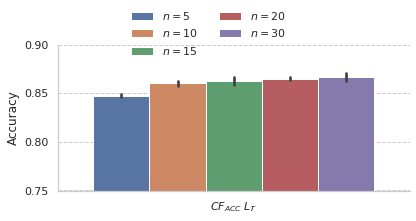

In [224]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8}, aspect=2)
g.map(sns.barplot, 'variable', 'value', 'name', palette="deep", hue_order=natsorted(np.unique(plot_df["name"])), order=np.unique(plot_df["variable"]))
g.set_titles('{col_name}')
g.set_axis_labels("", 'Accuracy')
g.add_legend(ncol=2, loc='upper center', title='')
g.set(ylim=(0.75, 0.9))
g.fig.savefig('figs/tune_tempo_rw_nwalks.pdf', format='pdf', bbox_inches='tight')
# TODO: show modularity

# Clustering Params

In [225]:
runs = api.runs("egordm/MGTCOM", {"$and": [
    {"group": {"$in": [
        "abl_clustering",
    ]}},
    {"state": 'finished'},
]})
print(f"Found {len(runs)} runs")

Found 109 runs


In [226]:
def preproc(run):
    history = run.history()
    history = history[history['epoch'] == history['epoch'].max()]

    return {
        'final_k': history['k'].values[0],
        'final_epoch': history['epoch'].values[0],
    }

runs_df = load_runs(runs, filter_summary=False, preprocess_fn=preproc)

## Sigma Scale

In [236]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^s=.*$', regex=True)]
len(plot_df)

22

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


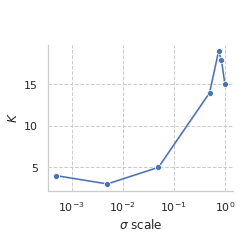

In [237]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'config.prior_sigma_scale', 'final_k', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels(r"$\sigma$ scale", '$K$')
g.add_legend(ncol=4, loc='upper center', title='')
plt.xscale('log')
g.fig.savefig('figs/cluster_sigma_scale.pdf', format='pdf', bbox_inches='tight')

## Alpha

In [238]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^a=.*$', regex=True)]
len(plot_df)

27

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


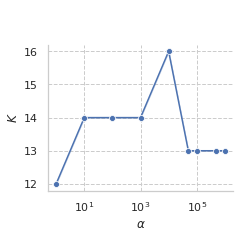

In [239]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'config.prior_alpha', 'final_k', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels(r"$\alpha$", '$K$')
g.add_legend(ncol=4, loc='upper center', title='')
plt.xscale('log')
g.fig.savefig('figs/cluster_alpha.pdf', format='pdf', bbox_inches='tight')

## Kappa

In [240]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^k=.*$', regex=True)]
len(plot_df)

33

In [241]:
plot_df

,summary.k,summary._runtime,summary.eval/val/clu/y/ari,summary.eval/val/clu/y/nmi,summary.eval/val/clu/conductance,summary.eval/val/clu/modularity,summary.eval/val/clu/label_snapshot_7/ari,summary._timestamp,summary.trainer/global_step,summary.eval/val/clu/louvain/ari,...,config.args.callback_params.clustering_visualizer.interval,config.args.callback_params.clustering_visualizer.cv_max_points,config.args.callback_params.clustering_visualizer.dim_reduction_mode,config.args.pretrained_path,config.args.optimizer_params.lr,name,group,final_k,final_epoch,model
0,15,72,0.149604,0.324503,0.695169,0.070609,0.089466,1655302180,-1,0.111504,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=500,abl_clustering,15.0,193,MGCOMComDetModel
1,9,54,0.140036,0.292507,0.737499,0.067532,0.076512,1655302096,-1,0.089147,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=50,abl_clustering,9.0,152,MGCOMComDetModel
2,17,93,0.175053,0.362478,0.772619,0.014972,0.075402,1655302032,-1,0.115969,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=0.05,abl_clustering,17.0,251,MGCOMComDetModel
3,15,56,0.146395,0.321699,0.785502,0.021714,0.069613,1655301928,-1,0.092761,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=0.005,abl_clustering,15.0,160,MGCOMComDetModel
4,15,71,0.149604,0.324503,0.695169,0.070609,0.089466,1655301861,-1,0.111504,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=500,abl_clustering,15.0,193,MGCOMComDetModel
5,15,60,0.147694,0.329286,0.569508,0.064263,0.081107,1655301778,-1,0.090235,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=50,abl_clustering,15.0,171,MGCOMComDetModel
6,17,95,0.175053,0.362478,0.772619,0.014972,0.075402,1655301708,-1,0.115969,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=0.05,abl_clustering,17.0,251,MGCOMComDetModel
8,15,61,0.146395,0.321699,0.785502,0.021714,0.069613,1655301598,-1,0.092761,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=0.005,abl_clustering,15.0,160,MGCOMComDetModel
10,15,79,0.149604,0.324503,0.695169,0.070609,0.089466,1655301526,-1,0.111504,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=500,abl_clustering,15.0,193,MGCOMComDetModel
11,9,58,0.140036,0.292507,0.737499,0.067532,0.076512,1655301434,-1,0.089147,...,100,10000,PCA,/data/pella/projects/University/Thesis/Thesis/...,0.01,k=50,abl_clustering,9.0,152,MGCOMComDetModel


/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


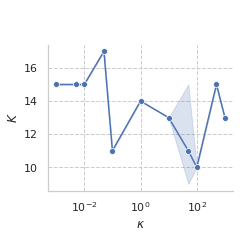

In [242]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'config.prior_kappa', 'final_k', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels(r"$\kappa$", '$K$')
g.add_legend(ncol=4, loc='upper center', title='')
plt.xscale('log')
g.fig.savefig('figs/cluster_kappa.pdf', format='pdf', bbox_inches='tight')

## Nu

In [243]:
plot_df = runs_df.copy()[runs_df.name.str.contains(r'^nu=.*$', regex=True)]
len(plot_df)

27

/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/data/pella/projects/University/Thesis/Thesis/source/env/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


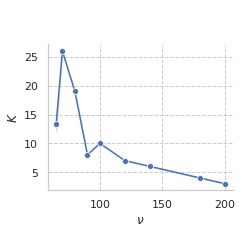

In [244]:
g = sns.FacetGrid(plot_df, gridspec_kws={"top":0.8})
g.map(sns.lineplot, 'config.prior_nu', 'final_k', markers=True, dashes=False, marker='o')
g.set_titles('{col_name}')
g.set_axis_labels(r"$\nu$", '$K$')
g.add_legend(ncol=4, loc='upper center', title='')
# plt.xscale('log')
g.fig.savefig('figs/cluster_nu.pdf', format='pdf', bbox_inches='tight')